In [ ]:
### All relevant data in 

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def read_alt_ref_geno(tab_file, min_mapq=0, min_svlen=50):
    """
    Expects a file with a line per SV in the following format:
    num_ref   num_alt   geno
    """
    counts = []
    with open(tab_file) as fin:
        for line in fin:
            ref_counts, alt_counts, geno, svlen_str, mapq  = line.rstrip().split()[0:5]
            svlen = np.abs(int(svlen_str))
            mapq = int(mapq)
            if svlen >= min_svlen and mapq >= min_mapq:
                counts.append([ref_counts, alt_counts, geno, svlen, mapq])
    df = pd.DataFrame(counts, columns=["ref", "alt", "genotype","svlen", "mapq"])
    df["ref"] = df["ref"].astype(int)
    df["alt"] = df["alt"].astype(int)
    df["svlen"] = df["svlen"].astype(int)
    df['genotype'] = df["genotype"].astype(str)
    #df.groupby("genotype")['ref'].agg(["count"])
    return df
    

def draw_allele_plot(counts, max_ref=60, max_alt=60):
    """Makes a scatter plot of allele support
    """
    num_points = len(counts)
    point_alpha = 10 / math.sqrt(max(100, num_points)) 
    geno = "1/1"
    plt.scatter(x=[ref+random.uniform(-0.5, 0.5) for ref in counts[counts.genotype == geno].ref],
                y=[alt+random.uniform(-0.5, 0.5) for alt in counts[counts.genotype == geno].alt],
                c='tab:red',
                alpha=point_alpha,
                label=geno,
                edgecolors='none')
    geno = "0/1"
    plt.scatter(x=[ref+random.uniform(-0.5, 0.5) for ref in counts[counts.genotype == geno].ref],
                y=[alt+random.uniform(-0.5, 0.5) for alt in counts[counts.genotype == geno].alt],
                c='tab:purple',
                alpha=point_alpha,
                label=geno,
                edgecolors='none')
    geno = "0/0"
    plt.scatter(x=[ref+random.uniform(-0.5, 0.5) for ref in counts[counts.genotype == geno].ref],
                y=[alt+random.uniform(-0.5, 0.5) for alt in counts[counts.genotype == geno].alt],
                c='tab:blue',
                alpha=point_alpha,
                label=geno,
                edgecolors='none')
    geno = "./."
    plt.scatter(x=[ref+random.uniform(-0.5, 0.5) for ref in counts[counts.genotype == geno].ref],
                y=[alt+random.uniform(-0.5, 0.5) for alt in counts[counts.genotype == geno].alt],
                c='tab:brown',
                alpha=point_alpha,
                label=geno,
                edgecolors='none')
    axes = plt.gca()
    axes.set_xlim([0, max_ref])
    axes.set_ylim([0, max_alt])
    plt.xlabel('Reference allele support')
    plt.ylabel('Variant allele support')
    leg = plt.legend(frameon=True,
               fontsize="medium")
    for lh in leg.legendHandles:
        lh.set_alpha(1.0)

def genotypes(counts):
    summary = counts.groupby("genotype")['ref'].agg(["count"])
    percentage = counts.groupby("genotype")['ref'].agg(["count"]).apply(lambda x:100 * x / float(x.sum()))
    df = pd.DataFrame({"counts": summary['count'], "%": percentage['count']})
    return df.round({'counts': 1, '%': 1})

### Distribution of alternate vs reference alleles in different datasets

- CHM1 môle hydatiforme (human double haploid, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4248323)
- Offspring of the second bovine trio (diploid)
- Maize F2
- Bees (haploid genome)

## Maize

In [3]:
%%bash
nanoporeDEL=maize/F4-B73-nanopoez-svim/variants.vcf 
bcftools query  -f '[%DP]\t[%AD]\t[%GT]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $nanoporeDEL | \
         vawkpy3 '{ split($2,a,","); print a[1], a[2], $3, $4, $6, $1, $5 }'| awk '$1!="." && $2!="."' | grep DEL > maize/nanopore_genotype_support.tsv

[W::vcf_parse_format] FORMAT 'CN' is not defined in the header, assuming Type=String


In [4]:
counts = read_alt_ref_geno("maize/nanopore_genotype_support.tsv", min_svlen=50)
genotypes(counts)

,counts,%
genotype,,
./.,2283,1.3
0/0,81372,45.2
0/1,41905,23.3
1/1,54401,30.2


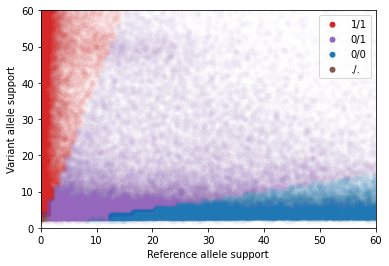

In [5]:
draw_allele_plot(counts)

In [6]:
counts = read_alt_ref_geno("maize/nanopore_genotype_support.tsv",min_mapq=20, min_svlen=50)
genotypes(counts)

,counts,%
genotype,,
0/0,4142,6.7
0/1,17051,27.7
1/1,40436,65.6


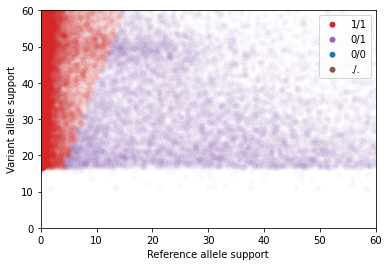

In [7]:
draw_allele_plot(counts)

In [8]:
%%bash
mantaDEL=maize/mantasv/mantasv/manta_DEL.vcf.gz
bcftools query  -f '[%SR]\t[%GT]\t[%GQ]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $mantaDEL | \
         vawkpy3 '{ split($1,a,","); print a[1], a[2], $2, $4, $6, $5, $3}' | grep -v "\." > maize/illumina_genotype_support.tsv

In [9]:
counts = read_alt_ref_geno("maize/illumina_genotype_support.tsv", min_svlen=50)
genotypes(counts)

,counts,%
genotype,,
0/1,676,3.8
1/1,16896,96.2


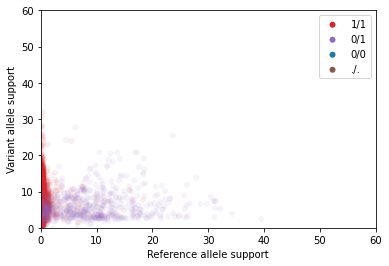

In [10]:
draw_allele_plot(counts)

## Bovine

In [11]:
%%bash
nanoporeDEL=bovine/Bovin-37160-nanopore-svim/final_results.vcf.gz
bcftools query  -f '[%DP]\t[%AD]\t[%GT]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $nanoporeDEL | \
         vawkpy3 '{ split($2,a,","); print a[1], a[2], $3, $4, $6, $1, $5 }'| awk '$1!="." && $2!="."' | grep DEL > bovine/nanopore_genotype_support.tsv

In [12]:
counts = read_alt_ref_geno("bovine/nanopore_genotype_support.tsv",min_svlen=50)
genotypes(counts)

,counts,%
genotype,,
./.,68,0.3
0/0,7981,35.7
0/1,10199,45.6
1/1,4129,18.5


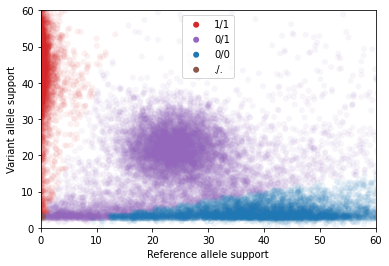

In [13]:
draw_allele_plot(counts)

In [14]:
%%bash
mantaDEL=bovine/mantasv/mantasv/manta_DEL.vcf.gz
#bcftools query  -f '[%SR]\t[%GT]\t[%GQ]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $mantaDEL | \
#         vawkpy3 '{ split($1,a,","); print a[1], a[2], $2, $4, $6, $5, $3}' | grep -v "\." > bovine/illumina_genotype_support.tsv

In [15]:
#counts = read_alt_ref_geno("bovine/illumina_genotype_support.tsv")
#genotypes(counts)

In [16]:
#draw_allele_plot(counts)

#### CHM13  hydatiforme 

In [17]:
%%bash
nanoporeDEL=CHM13/CHM13vsHs37d5/variants.vcf
bcftools query  -f '[%DP]\t[%AD]\t[%GT]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $nanoporeDEL | \
         vawkpy3 '{ split($2,a,","); print a[1], a[2], $3, $4, $6, $1, $5 }'| awk '$1!="." && $2!="."' | grep DEL > CHM13/nanopore_genotype_support.tsv 

[W::vcf_parse_format] FORMAT 'CN' is not defined in the header, assuming Type=String


In [18]:
counts = read_alt_ref_geno("CHM13/nanopore_genotype_support.tsv")
genotypes(counts)

,counts,%
genotype,,
./.,11,0.1
0/0,11224,57.4
0/1,3413,17.5
1/1,4892,25.0


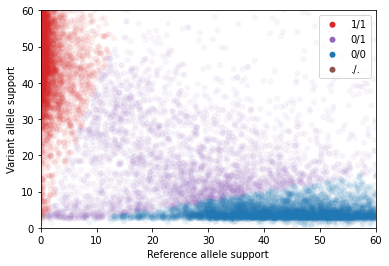

In [19]:
draw_allele_plot(counts)

In [20]:
counts = read_alt_ref_geno("CHM13/nanopore_genotype_support.tsv",min_mapq=20, min_svlen=50)
genotypes(counts)

,counts,%
genotype,,
0/0,569,8.0
0/1,1808,25.3
1/1,4770,66.7


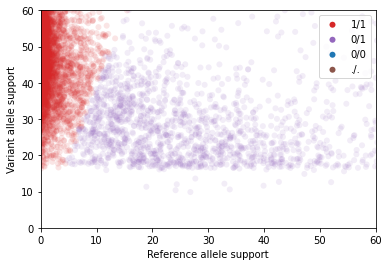

In [21]:
draw_allele_plot(counts)

In [22]:
%%bash
mantaDEL=CHM13/mantasv/mantasv/manta_DEL.vcf.gz
bcftools query  -f '[%SR]\t[%GT]\t[%GQ]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $mantaDEL | \
         vawkpy3 '{ split($1,a,","); print a[1], a[2], $2, $4, $6, $5, $3}' | grep -v "\." > CHM13/illumina_genotype_support.tsv

In [23]:
counts = read_alt_ref_geno("CHM13/illumina_genotype_support.tsv")
genotypes(counts)

,counts,%
genotype,,
0/1,331,10.0
1/1,2985,90.0


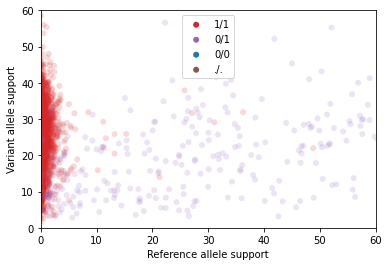

In [24]:
draw_allele_plot(counts)

## Bees

In [25]:
%%bash
mantaDEL=bee/single_manta_DEL.vcf.gz
bcftools query  -f '[%SR]\t[%GT]\t[%GQ]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $mantaDEL | \
         vawkpy3 '{ split($1,a,","); print a[1], a[2], $2, $4, $6, $5, $3}' | grep -v "\." > bee/illumina_genotype_support.tsv

In [26]:
counts = read_alt_ref_geno("bee/illumina_genotype_support.tsv")
genotypes(counts)

,counts,%
genotype,,
0/1,630,15.6
1/1,3416,84.4


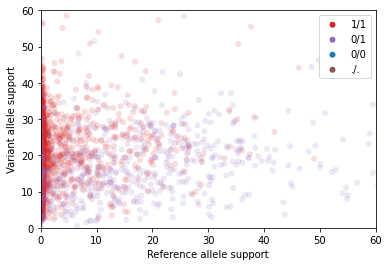

In [27]:
draw_allele_plot(counts)

### Goat

In [28]:
%%bash
mantaDEL=goat/FRCH-CRE-0016-manta.vcf.gz
#bcftools query  -f '[%SR]\t[%GT]\t[%GQ]\t%INFO/SVLEN\t%INFO/SVTYPE\t%QUAL\n' $mantaDEL | \
#         vawkpy3 '{ split($1,a,","); print a[1], a[2], $2, $4, $6, $5, $3}' | grep -v "\." | grep DEL > goat/illumina_genotype_support.tsv

In [29]:
#counts = read_alt_ref_geno("goat/illumina_genotype_support.tsv",min_mapq=20)
#genotypes(counts)

In [30]:
#draw_allele_plot(counts, max_ref=30, max_alt=30)